# Walmart Sales Prediction

## Introduction

The project intends to predict the weekly sales of departments in different Walmart stores using the best performance model picked from cross validation. The historical data used for training purpose include 45 Walmart stores located in different regions and each of them contains a number of departments. The testing data is identical to historical data except that the weekly sales is withheld and requires prediction. The project has also built a extensible training-testing structure where algorithms like recurrent neural network (RNN), support vector machine (SVM) can be implemented to build the model in a structured way under the sklearn package.

This notebook leads you through a "full stack" data science problem under the real world retailing scene, including data exploration, data processing and data analysis. Though data exploration can be an important part in practical data science problem, due to the volumn of our Walmart sales dataset, the focus of this project will primarily focus more on how to clean the data and statistical inferences. The dataset is acquired from course faculty for educational and training purpose.

###### train.csv
Training sales data from 2010-02-05 to 2012-10-26<br>
 - Store: the store number
 - Dept: the department number
 - Date: interval by week
 - Weekly_Sales: sales for department in a given store
 - IsHoliday: whether the week is a special holiday week

###### test.csv
Testing sales data from 2012-11-02 to 2013-07-26 <br>
- Fields are the same as train.csv except the Weekly_Sales is withheld 

###### features.csv
This file contains additional information related to stores and departments <br>
- Store: the store number
- Date: interval by week
- Temperature: average temperature in the region
- Fuel_Price: cost of fuel in the region
- MarkDown1-5: anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI: the consumer price index
- Unemployment: the unemployment rate
- IsHoliday: whether the week is a special holiday week

###### stores.csv
The file contains the size and type of the store <br>
- Type: type of the stores
- Size: size of the stores


## Installation

Before getting started, you'll need to install various packages that will be used in this project. It is strongly recommanded to use Anaconda since all the open source packages can be individually installed from the Anaconda repository. By calling

   $ pip install [packages you want to install]
   
Or

   $ conda install [packages you want to install]
   
Anaconda compiles and builds all the packages in the Anaconda repository itself. The packages required are listed as follow.

You can also refer to requirements.txt to figure out the required packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
# from sklearn.svm import SVR
# from sklearn.feature_selection import RFE
# from sklearn.neural_network import MLPRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import train_test_split
# import zipfile
# import pickle
# import csv
# import sqlite3
# import math
# import os

## Data Exploration

The first thing we need to do is to load data into the dataframe. Generally in some data science problems, we may want to use only one dataframe to include all of the fields that we need. Here we simply provide one alternative to achieve this.

In [2]:
# Load data into dataframe
features = pd.read_csv("features.csv.zip")
test = pd.read_csv("test.csv.zip")
train = pd.read_csv("train.csv.zip")
stores = pd.read_csv("stores.csv")

# Join table
df_train = train.merge(stores, left_on = "Store", right_on = "Store", how = "left").merge(
                features, left_on = ["Store", "Date"], right_on = ["Store", "Date"], how = "left")

# Reset index to be the composite pk
df_train.set_index(["Date", "Store", "Dept"], inplace=True)

# Get the first few rows of data
df_train.head()


,,,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,Store,Dept,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [3]:
df_train.tail()

,,,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,Store,Dept,,,,,,,,,,,,,,
2012-09-28,45,98,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False
2012-10-05,45,98,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False
2012-10-12,45,98,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False
2012-10-19,45,98,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False
2012-10-26,45,98,1076.80,False,B,118221,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,False


In [4]:
df_train.describe()

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In addition to matplotlib, seaborn is another useful package that you may want to use to explore when you first get your dataset. Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. Compared to matplotlib, seaborn can produce some nice features figrues that are more presentable. If you have some experience in RShiny package, seaborn will generate the graphics in a similar way with some nice color and background on it. Here we plot the distribution of Weekly_Sales and how it varies with date.

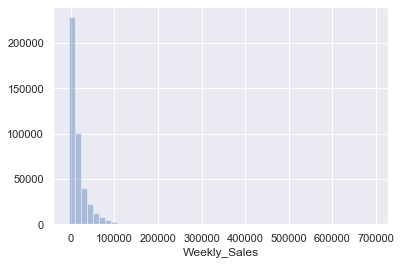

In [5]:
sns.distplot(train["Weekly_Sales"], kde=False, rug=False)

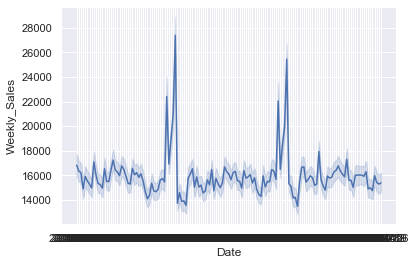

In [6]:
sns.lineplot(x="Date", y="Weekly_Sales", data=train)

We can see that the weekly sales in training dataset has a left skewed distribution. As for the weekly sales variation with date, two sales peaks are identified during our training data time range, some of the departments might have better sales performance than the others.

## Data Processing

Sometimes, it might be helpful to figure out the correlation among your target variables before implementing your regression analysis. In terms of feature engineering, we may want to include variables that have strong relations with weekly sales while eliminating those that are dependent on each other. After we get our dataset and convert it into the dataframe format, we can simply call corr function on the dataframe and it will automatically calculate all the possible combination pairs and organize it into matrix format.

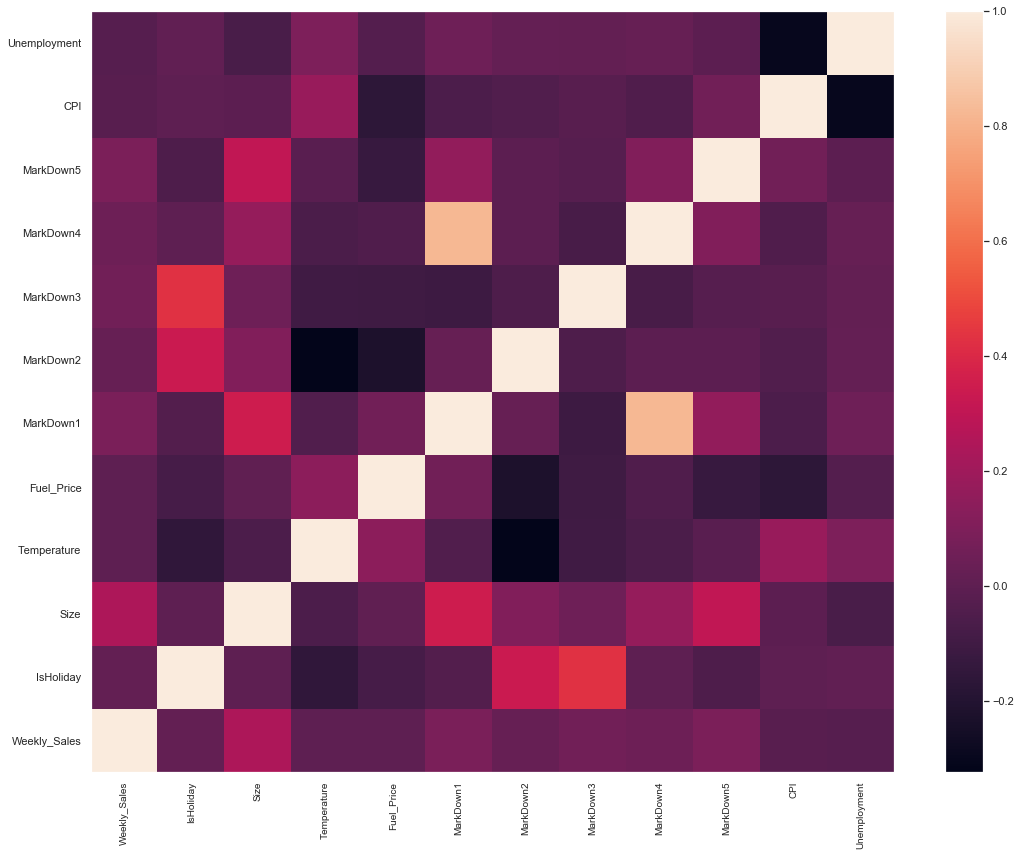

In [7]:
# Drop duplicate "isHoliday" Column
df_train = df_train.rename(columns = {"IsHoliday_x" : "IsHoliday"})
df_train = df_train.drop(columns = ["IsHoliday_y"])


# Inspect the correlation between Weekly_Sales and other independent variables. 
fig = plt.figure(figsize=(18, 14))
corr = df_train.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns, rotation = "vertical", fontsize = 10)
fig.colorbar(c)
plt.show()

By inspecting the brightness of the cell, "Weekly_Sales" has relatively weak correlation with "Unemployment", therefore column "Unemployment" will be dropped for further processing. It can be identified from the summary table that "MarkDown2", "MarkDown3" have negatvie values, which are not intepretable by the definition of markdown. All of "NaN' and negative values will be replaced by 0.

In [8]:
# Drop the unemployment column
try:
    df_train.drop(columns = ["Unemployment"], inplace=True)
except:
    None


# Fill NA and negative values in markdown with 0
df_train = df_train.fillna(0)
df_train.loc[df_train["MarkDown3"] < 0.0, "MarkDown3"] = 0.0
df_train.loc[df_train["MarkDown2"] < 0.0, "MarkDown2"] = 0.0
df_train.describe()

# Notice: we may want to sort the data to ensure efficient indexing in this large dataset,
# but since the data has already been ordered by date for practical usage, we may sacrifice
# some of the performance here.

C:\Users\DavidGuo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2854: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,15981.258123,136727.915739,60.090059,3.361027,2590.074819,880.070274,468.092929,1083.132268,1662.772385,171.201947
std,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.520381,5528.872994,3894.529945,4207.629321,39.159276
min,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,0.000000,0.000000,0.000000,0.000000,126.064000
25%,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667
50%,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780
75%,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993
max,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807


From the summary table above, the minimum value in "MarkDown2" column has been reset to 0.

In [9]:
types = stores["Type"].unique()
types

array(['A', 'B', 'C'], dtype=object)

In order to perform cross validation on training data set, all of the values should be numeric. Therefore the "Type" column, where originally filled with categorical variable "A", "B" and "C", will be converted into dummy variables as columns.

In [10]:
try:
    df_train = pd.get_dummies(df_train, columns=["Type"])
except:
    None
    
type_A = df_train["Type_A"].unique()
type_B = df_train["Type_B"].unique()
type_C = df_train["Type_C"].unique()
type_A, type_B, type_C

(array([1, 0], dtype=uint64),
 array([0, 1], dtype=uint64),
 array([0, 1], dtype=uint64))

In [11]:
df_train.head()

,,,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Type_A,Type_B,Type_C
Date,Store,Dept,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,1,0,0
2010-02-12,1,1,46039.49,True,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,1,0,0
2010-02-19,1,1,41595.55,False,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,1,0,0
2010-02-26,1,1,19403.54,False,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,1,0,0
2010-03-05,1,1,21827.90,False,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,1,0,0


## K-Fold Cross Validation

Cross-validation is one of the industry standard for model testing and selection. Sometimes, the choice of number of spliting data into training and testing sets is somewhat arbitrary. As we might expect, splitting a small dataset may yield an overestimate of model's prediction error, and the number of splits should be larger for datasets with fewer observation. Leave-one-out cross-validation can provide an unbiased estimate of prediction error but tends to be noisy.

In our dataset, cross validation is implemented in a way to randomly assign fold numbers to each (Store, Dept) pair as a separate column, based on the user input. And each fold will be used as the testing/validation set alternatively to figure out the best performance model. An assignment function is given as follow to perform the task. The example use 2 folds just for description purpose. You should adjust the fold number beyond 5 to ensure the accuracy of cross validation. But keep in mind a large fold number may overkill your computer memory since this is a relatively big dataset.

In [12]:
# Inspect the first and last group
result = [g[1] for g in list(df_train.groupby(["Store", "Dept"]))[:]]
result[0].head()

,,,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Type_A,Type_B,Type_C
Date,Store,Dept,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,1,0,0
2010-02-12,1,1,46039.49,True,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,1,0,0
2010-02-19,1,1,41595.55,False,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,1,0,0
2010-02-26,1,1,19403.54,False,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,1,0,0
2010-03-05,1,1,21827.90,False,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,1,0,0


In [13]:
result[-1].head()

,,,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Type_A,Type_B,Type_C
Date,Store,Dept,,,,,,,,,,,,,,
2010-02-05,45,98,347.23,False,118221,27.31,2.784,0.0,0.0,0.0,0.0,0.0,181.871190,0,1,0
2010-02-12,45,98,553.25,True,118221,27.73,2.773,0.0,0.0,0.0,0.0,0.0,181.982317,0,1,0
2010-02-19,45,98,281.00,False,118221,31.27,2.745,0.0,0.0,0.0,0.0,0.0,182.034782,0,1,0
2010-02-26,45,98,2.50,False,118221,34.89,2.754,0.0,0.0,0.0,0.0,0.0,182.077469,0,1,0
2010-03-05,45,98,4.50,False,118221,37.13,2.777,0.0,0.0,0.0,0.0,0.0,182.120157,0,1,0


In [14]:
dataset = []
# You can adjust the folds on your preference (recommand larger than 5)
folds = 2

# Randomly assign fold number based on user input.
def assignment(folds):
    
    #  Perform analysis on each (store, dept) group
    for key, group in df_train.reset_index().groupby(["Store", "Dept"]):
        group = group.reset_index(drop=True)
        
        #  Rows in our group is smaller than or equal to the fold number.
        if group.shape[0] <= folds:
            f = np.array(range(folds))
            np.random.shuffle(f)
            group["fold"] = f[:group.shape[0]]
            continue
            
        #  Rows in our group is larger than the fold number.
        repeats = np.array(range(folds))
        repeats = np.tile(repeats, len(group)//folds+1)[:len(group)]
        np.random.shuffle(repeats)
        group["fold"] = repeats

        dataset.append(group)
    return dataset

dataset = assignment(folds)
dataset = pd.concat(dataset).reset_index(drop=True)
dataset = dataset.drop(columns = ["Date"])

dataset.head()  
        
    

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Type_A,Type_B,Type_C,fold
0,1,1,24924.50,False,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,1,0,0,1
1,1,1,46039.49,True,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,1,0,0,1
2,1,1,41595.55,False,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,1,0,0,1
3,1,1,19403.54,False,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,1,0,0,0
4,1,1,21827.90,False,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,1,0,0,0


Now we have the dataset with folds assigned. By iterating the fold number and assigning weight to holiday, we can pick up the best performance model.

In [15]:
def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))


#  Extend the ML framework for future usage
def model_():
#     return knn()
    return extraTreesRegressor()
#     return svm()
#     return nn()
#     return randomForestRegressor()

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)


best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(folds):
    train_set = dataset.loc[dataset["fold"] != fold]
    test_set = dataset.loc[dataset["fold"] == fold]
    train_y = train_set["Weekly_Sales"]
    train_x = train_set.drop(columns=["Weekly_Sales", "fold"])
    test_y = test_set["Weekly_Sales"]
    test_x = test_set.drop(columns=["Weekly_Sales", "fold"])
    
    # Print out the shape of train and test dataset.
    print(train_set.shape, test_set.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    
    # Assign weight to holiday 5 times 
    weights = test_x["IsHoliday"].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    
    # Print out which folder we are in and the mean absolute error of this assignment
    print(fold, error)
    
    # Print out info every time we find a better performance model
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
        
# Calculate the average mean absolute error.
error_cv /= 2

(209252, 17) (212221, 17)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


0 2474.757570584937
Find best model
(212221, 17) (209252, 17)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


1 2457.252392807034
Find best model


The average mean absolue error of our 2-fold cross validation model is indicated as follows:

In [16]:
error_cv

2466.0049816959854

## Predication on Testing Data

In most cases, cross-validation is used to help us properly separate our training and testing/validation dataset prepared for further analysis with advanced ML algorithms. In this program, the focus will be on cross-validation itself, therefore we feed our best performance model with extra provided testing dataset. Some data cleaning processes on the testing dataset are described below.

In [17]:
# Join table
df_test = test.merge(stores, left_on = "Store", right_on = "Store", how = "left").merge(
                features, left_on = ["Store", "Date"], right_on = ["Store", "Date"], how = "left")

# Drop duplicate "isHoliday" Column
df_test = df_test.rename(columns = {"IsHoliday_x" : "IsHoliday"})
df_test = df_test.drop(columns = ["IsHoliday_y"])

# Drop the unemployment column
try:
    df_test.drop(columns = ["Unemployment"], inplace=True)
except:
    None

# Fill NA and negative values in markdown with 0
df_test = df_test.fillna(0)
df_test.loc[df_test["MarkDown3"] < 0.0, "MarkDown3"] = 0.0

# Convert type to dummy variable
try:
    df_test = pd.get_dummies(df_test, columns=["Type"])
except:
    None

df_test.drop(columns = ["Date"], inplace=True)



In [18]:
df_test.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Type_A,Type_B,Type_C
0,1,1,False,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,1,0,0
1,1,1,False,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,1,0,0
2,1,1,False,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,1,0,0
3,1,1,True,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,1,0,0
4,1,1,False,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,1,0,0


In [19]:
predicted_test = best_model.predict(df_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


In [20]:
len(predicted_test)

115064

Now we have our weekly sales prediction on (store, dept) group by date. We reorganize it into an output dataframe to indicate how sales performance varies with date within each department at different store.

In [21]:
df_test["Weekly_Sale"] = predicted_test
df_test["Date"] = test["Date"]
output_test = df_test[["Date", "Store", "Dept", "Weekly_Sale"]]
output_test

,Date,Store,Dept,Weekly_Sale
0,2012-11-02,1,1,24051.3239
1,2012-11-09,1,1,20691.8476
2,2012-11-16,1,1,26191.0507
3,2012-11-23,1,1,23493.8970
4,2012-11-30,1,1,32055.8181
5,2012-12-07,1,1,22933.3501
6,2012-12-14,1,1,30822.3734
7,2012-12-21,1,1,32818.6719
8,2012-12-28,1,1,42642.9242
9,2013-01-04,1,1,40547.1573


In [22]:
# Uncomment this line if you want to have a csv output
# output_test.to_csv('output.csv', index=False)

## Conclusion

The actual sales data in our prediction time range is not published, but we still have several ways to validate the accuracy of our prediction. By directly inspecting the result above, each department has its own sales pattern so the values of sales prediction fall into a relatively closer range, which indicate our predictions to some extent make sense. As mentioned before, the cross-validation method is generally used to separate the training and testing/validation set to evaluate the performance of the model. In terms of the practical application of this dataset, the future effort includes implementing more advanced statistical and ML algorithms to conduct further analysis.

## References

1. Pandas: https://pandas.pydata.org/
2. Numpy: https://numpy.org/
3. Matplotlib: https://matplotlib.org
4. Seaborn: https://seaborn.pydata.org
5. Scikit-learn: https://scikit-learn.org/stable/